In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

2025-06-12 07:38:19.990551: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749713900.175419      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749713900.234409      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Paths**

In [2]:
base_dir = "/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset" 

In [3]:
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")



**Parameters**

In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 8

**Data Augmentation & Normalization**

In [5]:
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 18400 files belonging to 8 classes.


I0000 00:00:1749713927.265887      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 2800 files belonging to 8 classes.
Found 2800 files belonging to 8 classes.


**class names**

In [6]:
class_names = train_ds_raw.class_names
print("Classes:", class_names)

Classes: ['AMD', 'CNV', 'CSR', 'DME', 'DR', 'DRUSEN', 'MH', 'NORMAL']


In [7]:
print("Val classes:", val_ds_raw.class_names)

Val classes: ['AMD', 'CNV', 'CSR', 'DME', 'DR', 'DRUSEN', 'MH', 'NORMAL']


**Prefetching for performance**

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_raw.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds_raw.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds_raw.prefetch(buffer_size=AUTOTUNE)

**Transfer Learning with ResNet50**

In [9]:
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False 

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Custom classification head**

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [12]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

**Checkpoint to save best model**

In [13]:
checkpoint_path = "best_model.h5"
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

**Train**

In [14]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=150,
    callbacks=[checkpoint_cb]
)

Epoch 1/150


I0000 00:00:1749714042.489012      99 service.cc:148] XLA service 0x7d1328002460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749714042.489697      99 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749714043.946433      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/575 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.0955 - loss: 2.4938   

I0000 00:00:1749714047.857908      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


575/575 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.1816 - loss: 2.0400
Epoch 1: val_accuracy improved from -inf to 0.34286, saving model to best_model.h5
575/575 ━━━━━━━━━━━━━━━━━━━━ 99s 65ms/step - accuracy: 0.1817 - loss: 2.0398 - val_accuracy: 0.3429 - val_loss: 1.7236
Epoch 2/150
575/575 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2939 - loss: 1.7177
Epoch 2: val_accuracy improved from 0.34286 to 0.39321, saving model to best_model.h5
575/575 ━━━━━━━━━━━━━━━━━━━━ 47s 49ms/step - accuracy: 0.2939 - loss: 1.7177 - val_accuracy: 0.3932 - val_loss: 1.5639
Epoch 3/150
575/575 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3546 - loss: 1.5772
Epoch 3: val_accuracy improved from 0.39321 to 0.42929, saving model to best_model.h5
575/575 ━━━━━━━━━━━━━━━━━━━━ 47s 49ms/step - accuracy: 0.3546 - loss: 1.5771 - val_accuracy: 0.4293 - val_loss: 1.4343
Epoch 4/150
574/575 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3809 - loss: 1.4863
Epoch 4: val_accuracy improved from 0.42929 to 0

**Load the best model**

In [15]:
model = tf.keras.models.load_model(checkpoint_path)

**evaluation**

In [16]:
loss, accuracy = model.evaluate(test_ds)
print(f"\nTest Accuracy: {accuracy:.2f}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - accuracy: 0.7735 - loss: 0.5925

Test Accuracy: 0.66


**prediction**

In [17]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━

**confusion matrix**

In [18]:
import seaborn as sns

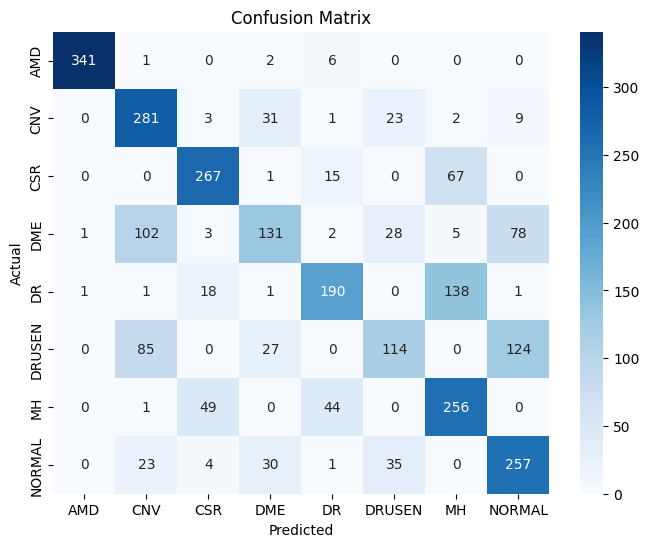

In [19]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


**classification report**

In [20]:
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))



Classification Report:

              precision    recall  f1-score   support

         AMD       0.99      0.97      0.98       350
         CNV       0.57      0.80      0.67       350
         CSR       0.78      0.76      0.77       350
         DME       0.59      0.37      0.46       350
          DR       0.73      0.54      0.62       350
      DRUSEN       0.57      0.33      0.41       350
          MH       0.55      0.73      0.63       350
      NORMAL       0.55      0.73      0.63       350

    accuracy                           0.66      2800
   macro avg       0.67      0.66      0.65      2800
weighted avg       0.67      0.66      0.65      2800

